In [1]:
import shnitsel as sh
import shnitsel.xarray
import xarray as xr
import matplotlib.pyplot as plt

# Load data

In [10]:
A02 = sh.open_frames('/tmp/A02_filtered.nc')
A03 = sh.open_frames('/tmp/A03_filtered.nc')

In [17]:
A03 = sh.open_frames('/tmp/homologs.nc').sel(cmpnd='A03')

# Calculate dihedrals & cluster

In [18]:
dih = A03.atXYZ.sh.dihedral(3, 1, 0, 2, deg=True)
dih['e_pot'] = A03.energy.sel(state=A03.astate).drop_vars('state')
dih['astate'] = A03.astate

In [19]:
end_dih = dih.groupby('trajid').last()
end_dih['ZZ'] = end_dih<80
end_dih['ZE'] = end_dih>100

trajids_ZZ = end_dih.trajid[end_dih['ZZ']]
ZZ = A03.sh.sel_trajs(trajids_ZZ)

trajids_ZE = end_dih.trajid[end_dih['ZE']]
ZE = A03.sh.sel_trajs(trajids_ZE)

In [20]:
end_dih#['ZE']

<xarray.DataArray 'dihedral' (trajid: 82)> Size: 656B
array([ 23.52452811, 174.10539531,  46.04370625, 116.7630419 ,
        77.08455839,  24.71559732, 117.60028495, 151.94377381,
       169.73132675,   0.43062016,  68.28400389,  24.6356212 ,
        86.66384339,  65.08287072,  71.1762763 ,  64.00386998,
        65.01699364,  55.96402683, 141.17296881,  13.57003825,
        57.04765885, 124.35516838,  61.8545503 ,  86.90770519,
        84.60120247,  96.98781166,  88.43441302,  32.79140231,
        97.77122218,  42.53777201, 159.03392377,  57.46922603,
        90.7016579 ,  86.12219287,  56.86852206,  28.90380415,
        37.52227985, 105.1810497 ,  91.25509345,  94.05296498,
        59.62459657, 121.10950738,  91.05599628,  74.7170842 ,
       111.37690692,  57.02438871,  19.97076646,  32.50943429,
       138.93993052,  60.86048303,  31.84746008,  97.05766543,
       116.59005853,  83.79680591, 161.34072687, 158.95966961,
        54.64945385,  84.24568497,   6.27759849,  91.29863693,
        77.38429927,  95.99498234,  21.25800963, 123.91973133,
        55.11771739, 128.56773058, 152.74328357,  64.39830346,
       150.225692  , 141.86784492,  56.06075583,  55.55737424,
       163.25722667,  27.86447899,  85.80930556,  63.55174502,
        41.37504505, 112.55037031, 131.40918585, 154.39556981,
        49.06936358, 163.70932658])
Coordinates:
    cmpnd    <U3 12B 'A03'
  * trajid   (trajid) int64 656B 3 13 20 24 25 27 28 ... 290 296 303 304 311 316
    ZZ       (trajid) bool 82B True False True False ... False False True False
    ZE       (trajid) bool 82B False True False True ... True True False True
Attributes:
    long_name:  $\varphi_{3,1,0,2}$

In [21]:
ZE

<xarray.Dataset> Size: 11MB
Dimensions:    (state: 3, frame: 6015, direction: 3, statecomb: 3, atom: 6,
                trajid_: 25)
Coordinates:
  * state      (state) int64 24B 1 2 3
  * atom       (atom) int64 48B 0 1 2 3 4 5
  * direction  (direction) <U1 12B 'x' 'y' 'z'
  * trajid_    (trajid_) int32 100B 13 24 28 30 31 57 ... 277 296 303 304 316
    atNames    (frame, atom) <U1 144kB ...
  * statecomb  (statecomb) object 24B MultiIndex
  * from       (statecomb) int64 24B 1 1 2
  * to         (statecomb) int64 24B 2 3 3
  * frame      (frame) object 48kB MultiIndex
  * trajid     (frame) int64 48kB 13 13 13 13 13 13 ... 316 316 316 316 316 316
  * time       (frame) float64 48kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
    cmpnd      <U3 12B 'A03'
Data variables: (12/13)
    energy     (state, frame) float64 144kB ...
    dip_perm   (state, direction, frame) float64 433kB ...
    dip_trans  (statecomb, direction, frame) float64 433kB ...
    sdiag      (frame) int64 48kB ...
    astate     (frame) int64 48kB 2 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1
    forces     (state, atom, direction, frame) float64 3MB ...
    ...         ...
    nacs       (statecomb, atom, direction, frame) float64 3MB ...
    atXYZ      (atom, direction, frame) float64 866kB ...
    max_ts     (trajid_, frame) float64 1MB ...
    completed  (trajid_, frame) float32 602kB ...
    nsteps     (trajid_, frame) float64 1MB ...
    e_kin      (frame) float64 48kB ...
Attributes:
    delta_t:  0.5

# Plot populations

In [22]:
import numpy as np

def _plot_pops(pops, ax=None, c='k'):
    if ax is None:
        _, ax = plt.subplots(1,1)
    for state, sdata in pops.groupby('state'):
        ls = sdata['_ls'].item()
        ax.plot(sdata['time'], sdata, c=c, ls=ls)
    ax.set_ylabel('Population')
    ax.set_xlabel('$t$ / fs')
    return ax
    
def pops_combine(frames, ax=None, c='k'):
    if ax is None:
        _, ax = plt.subplots(1,1)
    pops = frames.sh.calc_pops()
    combined = xr.DataArray(
        np.c_[pops[:, 0], pops[:, [1, 2]].sum('state')],
        coords=[pops.time, ('state', [s[1] for s in COMBINED_STATES])]
    )
    combined['_ls'] = 'state', [s[0] for s in COMBINED_STATES]
    _plot_pops(combined, ax, c=c)
    return ax


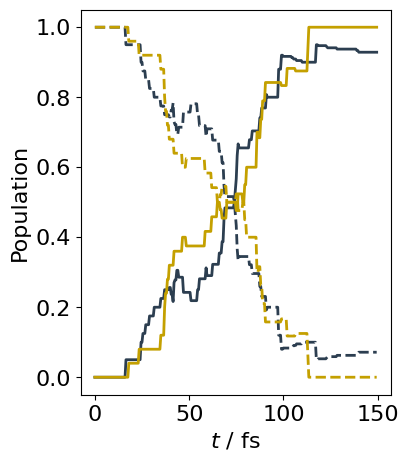

In [27]:
from matplotlib.lines import Line2D

ensembles = [
    # (A03, '#7E5273', r'$\mathbf{A03}$ (all)'),
    # (ZZ, '#2c3e50', r'$\mathbf{A03}$ ($Z\rightarrow Z$)'),
    # (A02, '#C4A000', r'$\mathbf{A02}$'),
    (ZZ, '#2c3e50', r'$\mathbf{A03}$'),
    (ZE, '#C4A000', r'$\mathbf{A03}$ ($Z\rightarrow E$)'),
]

COMBINED_STATES = [
    ('-', '$S_0$'),
    ('--', '$S_1$ & $S_2$')
]

def leg(label, **kwargs):
    return Line2D([0], [0], label=label, **kwargs)

linestyles = [leg(lb, c='k', ls=ls) for ls, lb in COMBINED_STATES]
colours = [leg(lb, c=c, ls='-') for _, c, lb in ensembles]

plt.rc('font', size=16)
plt.rc('lines', linewidth=2)

fig, ax = plt.subplots()
fig.set_size_inches(4, 5)
for data, c, lb in ensembles:
    pops_combine(data, ax, c=c)
handles = colours
# handles = linestyles + colours
# ax.legend(handles=handles, loc='center right')
fig.savefig('/nc/reports/2025-06-30_4-step_figure/4_new.pdf')